<h1 style="color: #FF5733;">Data Cleaning & Pre-processing</h1>

In [23]:
#Import The DataSet And Necessary Libraries
import os 
os.chdir ("C:\\Users\\PC\\Desktop")
import pandas as pd
df= pd.read_csv("C:\\Users\\PC\\Desktop\\Dataset_Uber Traffic.csv")

In [27]:
#Exploratory Data Analysis
df.head()

,DateTime,Junction,Vehicles,ID
0,01/11/15 0:00,1,15,20151101001
1,01/11/15 1:00,1,13,20151101011
2,01/11/15 2:00,1,10,20151101021
3,01/11/15 3:00,1,7,20151101031
4,01/11/15 4:00,1,9,20151101041


In [29]:
#Summary statistics
df.describe()

,Junction,Vehicles,ID
count,48120.000000,48120.000000,4.812000e+04
mean,2.180549,22.791334,2.016330e+10
std,0.966955,20.750063,5.944854e+06
min,1.000000,1.000000,2.015110e+10
25%,1.000000,9.000000,2.016042e+10
50%,2.000000,15.000000,2.016093e+10
75%,3.000000,29.000000,2.017023e+10
max,4.000000,180.000000,2.017063e+10


In [31]:
#Information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [33]:
#Check for missing values
df.isnull().sum()

DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64

**As we see their is no missing values in the data_set .so no need to handle the missing values.** 

In [35]:
#Check For Duplicates Values
df.duplicated().sum()

0

**As we see their is no Duplicates values in the data_set .so no need to handle the Duplicates values..**

In [37]:
#Convert DateTime Column to datetime formate
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%d/%m/%y %H:%M')

In [39]:
df.head(10)

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041
5,2015-11-01 05:00:00,1,6,20151101051
6,2015-11-01 06:00:00,1,9,20151101061
7,2015-11-01 07:00:00,1,8,20151101071
8,2015-11-01 08:00:00,1,11,20151101081
9,2015-11-01 09:00:00,1,12,20151101091


In [41]:
#Aggregate traffic data into hourly intervals
df_hourly = df.groupby([pd.Grouper(key='DateTime', freq='h'), 'Junction']).agg({'Vehicles': 'sum'}).reset_index()
df_hourly.rename(columns={'ID': 'Record_Count'}, inplace=True)
df_hourly.head()

,DateTime,Junction,Vehicles
0,2015-11-01 00:00:00,1,15
1,2015-11-01 00:00:00,2,6
2,2015-11-01 00:00:00,3,9
3,2015-11-01 01:00:00,1,13
4,2015-11-01 01:00:00,2,6


In [43]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Create a copy of the DataFrame for processing
df_normalized = df_hourly.copy()
df_standardized = df_hourly.copy()

### 1. Normalize Vehicles (0 to 1 range)
scaler = MinMaxScaler()
df_normalized['Vehicles_Normalized'] = scaler.fit_transform(df_hourly[['Vehicles']])

### 2. Standardize Vehicles (Mean = 0, Std = 1)
scaler = StandardScaler()
df_standardized['Vehicles_Standardized'] = scaler.fit_transform(df_hourly[['Vehicles']])

# Display the results
print(df_normalized.head(10))
print(df_standardized.head(10))

             DateTime  Junction  Vehicles  Vehicles_Normalized
0 2015-11-01 00:00:00         1        15             0.078212
1 2015-11-01 00:00:00         2         6             0.027933
2 2015-11-01 00:00:00         3         9             0.044693
3 2015-11-01 01:00:00         1        13             0.067039
4 2015-11-01 01:00:00         2         6             0.027933
5 2015-11-01 01:00:00         3         7             0.033520
6 2015-11-01 02:00:00         1        10             0.050279
7 2015-11-01 02:00:00         2         5             0.022346
8 2015-11-01 02:00:00         3         5             0.022346
9 2015-11-01 03:00:00         1         7             0.033520
             DateTime  Junction  Vehicles  Vehicles_Standardized
0 2015-11-01 00:00:00         1        15              -0.375489
1 2015-11-01 00:00:00         2         6              -0.809227
2 2015-11-01 00:00:00         3         9              -0.664648
3 2015-11-01 01:00:00         1        13      

<mark>**Data Cleaning Summary:
1 Missing Values: None found.
2 Duplicates: None detected (and removed if present).
3 DateTime Conversion: Successfully converted to datetime format.
4 Aggregation: Data is now grouped by hourly intervals and junction with total vehicle counts.
5 Normalisation and standardized the dataset**</mark>

<h1 style="color: #FF5733;">Feature Engineering and Selection</h1>

***1. Create new features from raw data***

**Generate time-based features such as hour of the day, day of the week, and month.
Develop lag features by including traffic data from previous hours or days to capture temporal dependencies
Create binary indicators for weekends and special events to account for their impact on traffic.**

Feature Importance:
 Lag_3        0.452506
Month        0.136652
Lag_2        0.133749
Lag_1        0.120531
Hour         0.080464
DayOfWeek    0.045928
IsWeekend    0.030171
dtype: float64


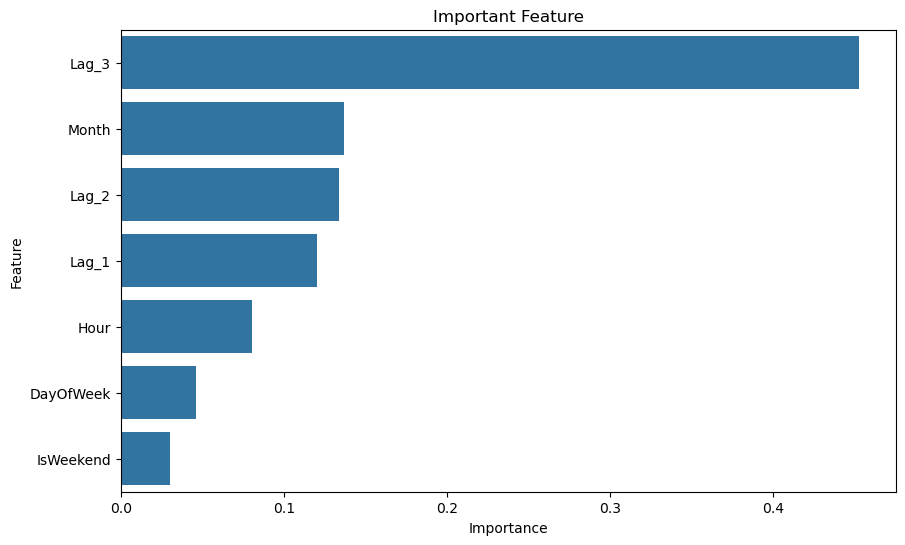

In [45]:
#import Necessary Libraries
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Time-based features
df_hourly['Hour'] = df_hourly['DateTime'].dt.hour
df_hourly['DayOfWeek'] = df_hourly['DateTime'].dt.dayofweek  # 0 = Monday, 6 = Sunday
df_hourly['Month'] = df_hourly['DateTime'].dt.month

# Binary indicator for weekends (1 for weekend, 0 for weekday)
df_hourly['IsWeekend'] =df_hourly['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Lag features (traffic from previous 1, 2, and 3 hours)
df_hourly['Lag_1'] = df_hourly['Vehicles'].shift(1)
df_hourly['Lag_2'] = df_hourly['Vehicles'].shift(2)
df_hourly['Lag_3'] = df_hourly['Vehicles'].shift(3)

# Drop rows with NaN (due to lag feature creation)
df_hourly.dropna(inplace=True)

# Step 2: Evaluate Feature Importance

# Prepare features and target
X = df_hourly[['Hour', 'DayOfWeek', 'Month', 'IsWeekend', 'Lag_1', 'Lag_2', 'Lag_3']]
y = df_hourly['Vehicles']

# Train a Random Forest model for feature importance
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Get feature importance
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Display feature importance
print("Feature Importance:\n", feature_importance)

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title("Important Feature")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


***2. Evaluate feature importance:***

***Statistical methods and machine learning techniques to assess the relevance of each feature.***

Feature Correlation with Vehicles:
 Vehicles     1.000000
Lag_3        0.320637
DateTime     0.266205
Hour         0.219896
Month       -0.022670
Lag_2       -0.041652
Lag_1       -0.095621
DayOfWeek   -0.125979
IsWeekend   -0.150503
Junction    -0.613810
Name: Vehicles, dtype: float64


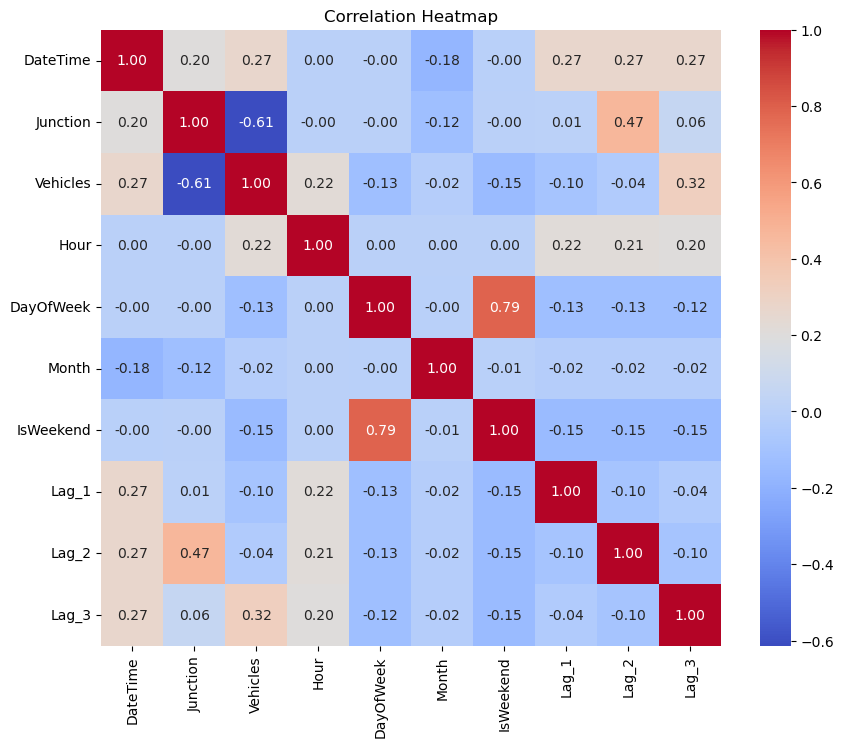

In [55]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency


# Separate features (X) and target (y)
X = df_hourly.drop(['Vehicles', 'DateTime'], axis=1)  # Features (assuming 'Vehicles' is the target)
y = df_hourly['Vehicles']                             # Target variable (Vehicle count)

### Step 1: Correlation Analysis (Numerical Features)
# Compute correlation matrix
correlation_matrix = df_hourly.corr()

# Display correlation with target
print("Feature Correlation with Vehicles:\n", correlation_matrix['Vehicles'].sort_values(ascending=False))

# Visualize correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


***Random Forest Feature Importance***

In [67]:
from sklearn.ensemble import RandomForestRegressor

# Separate features and target
X = df_hourly.drop(['Vehicles', 'DateTime'], axis=1)
y = df_hourly['Vehicles']

# Train Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Display feature importance
importances = pd.Series(model.feature_importances_, index=X.columns)
print("\nFeature Importances:\n", importances.sort_values(ascending=False))

# Select features with importance > 0.05
important_features = importances[importances > 0.05].index.tolist()
print("\nSelected Features (Importance > 0.05):\n", important_features)


Feature Importances:
 Junction     0.505680
Lag_2        0.243692
Lag_3        0.090492
Lag_1        0.050026
Hour         0.042534
Month        0.037596
DayOfWeek    0.019946
IsWeekend    0.010034
dtype: float64

Selected Features (Importance > 0.05):
 ['Junction', 'Lag_1', 'Lag_2', 'Lag_3']


***Recursive Feature Elimination (RFE)***

In [73]:
from sklearn.feature_selection import RFE

# Use Random Forest for feature elimination
rfe = RFE(estimator=model, n_features_to_select=5)
rfe.fit(X, y)

# Get selected features
rfe_selected_features = X.columns[rfe.support_]
print("\nFeatures selected by RFE:\n", rfe_selected_features.tolist())


Features selected by RFE:
 ['Junction', 'Hour', 'Lag_1', 'Lag_2', 'Lag_3']


***The most influential features for model training to improve efficiency and performance.***

In [59]:
from sklearn.ensemble import RandomForestRegressor
X = df.drop(['Vehicles', 'DateTime'], axis=1)  # Features
y = df['Vehicles']                             # Target (Vehicle count)

# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Get feature importance
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
print("Feature Importance:\n", feature_importance.sort_values(ascending=False))

# Keep features with importance > 0.05
important_features = feature_importance[feature_importance > 0.05].index
print("\nSelected Features:\n", important_features.tolist())



Feature Importance:
 Junction    0.657751
ID          0.342249
dtype: float64

Selected Features:
 ['Junction', 'ID']


<mark>***Summary of Feature Engineering:-1. created new features like hour of the day, day of the week etc. 2. Evaluated Feature Importance by using correlation heatmap / analysis. 3. Selected the Most Influential Features.***</mark>  